In [93]:
import ternausnet.models
import numpy as np 
import torch
model = ternausnet.models.UNet11(pretrained=False)
model.load_state_dict(torch.load('model-latest.pth'))
model = model.to(device='cuda:0')

In [94]:
im_path = 'datasets/sentinel/images/bulgaria_iskar_s2cloudless_2016.png'

In [95]:
from PIL import Image
import numpy as np

In [96]:
I = np.asarray(Image.open(im_path))

L1, L2 = I.shape[:2]
m = 224
M = 448
d = m + np.argmin(np.maximum(L1 % np.arange(m, M), L2 % np.arange(m, M)))

crops = []

for k, K in zip(list(range(0, L1 - d, d)), list(range(d, L1 - d, d)) + [L1]):
    for p, P in zip(list(range(0, L2 - d, d)), list(range(d, L2 - d, d)) + [L1]):
        crops.append(I[k:K, p:P])

In [97]:
import cv2

In [98]:
batch = np.stack(list(map(lambda x: cv2.resize(x, (224, 224), interpolation=cv2.INTER_AREA), crops)))

In [99]:
batch = ((batch / 255) - np.array([0.485, 0.456, 0.406])[None, None, None, :]) / np.array([0.229, 0.224, 0.225])[None, None, None, :]

In [100]:
batch = torch.tensor(batch, dtype=torch.float).to(device='cuda:0')

In [101]:
batch.shape

torch.Size([255, 224, 224, 3])

In [102]:
batch = batch.transpose(2,3).transpose(1,2)

In [103]:
batch.shape

torch.Size([255, 3, 224, 224])

In [104]:
batch_size = 10

In [105]:
res = np.concatenate(list(map(lambda x: (model(x) > 0.5).detach().cpu().float().numpy().astype(np.uint8) * 255, torch.split(batch, batch_size))))

In [106]:
res.shape

(255, 1, 224, 224)

In [107]:
II = np.zeros_like(I[:, :, 0])

In [108]:
i = 0
for k, K in zip(list(range(0, L1 - d, d)), list(range(d, L1 - d, d)) + [L1]):
    for p, P in zip(list(range(0, L2 - d, d)), list(range(d, L2 - d, d)) + [L1]):
        res_ = cv2.resize(res[i, 0], crops[i].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        II[k:K, p:P] = res_
        i += 1

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(III)

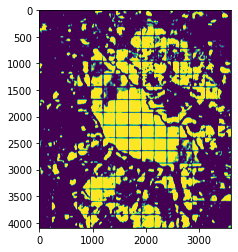

In [109]:
plt.imshow(II)

In [88]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [118]:
III=I.copy()
III[:, :, 2] =cv2.morphologyEx(II, cv2.MORPH_GRADIENT, np.ones((5,5), dtype=np.uint8))

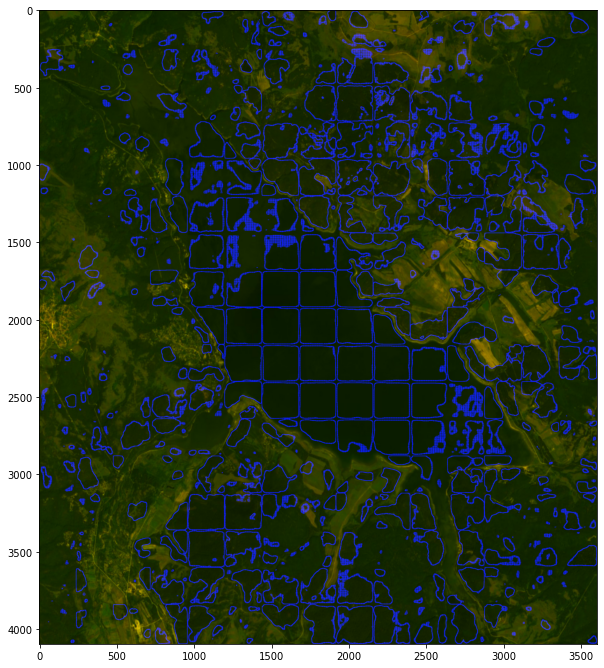

In [119]:
plt.figure(figsize=(10,20))
plt.imshow(III)